In [1]:
import json
import jax
import jax.numpy as jnp
import jax.random as jrandom
from functools import partial
# Some small helper functions
from sim_core.discrete import Empirical
from sim_core.independent import Independent
from sim_core.sde import VESDE
from train_interface.data_handling import random_nan, normalize_data, normalize_with_params
from train_interface.Visualize import plot_pairplot_comparison_points

from build_transfomer_model import BuildTransformerModel
from wrapper import SimFormer
from config_class import TrainingConfig, SDEConfig, SimformerConfig, TransformerConfig, DiffusionConfig, set_config_values

import matplotlib.pyplot as plt
# Check CUDA support
jax.devices()
# Set random key
key = jax.random.PRNGKey(5)

### 1) Data Generation


## Data Generation Functions

### **Theta Generation**
- $\theta_1 \sim \mathcal{N}(0, 3)$
- $\theta_2 \sim \mathcal{N}(0, 2)$

---

### **Data Features Calculation**
- **$x_1$** = $2 \cdot \sin(\theta_1) + 3 \cdot \cos(\theta_2) + \mathcal{N}(0, 0.5)$
- **$x_2$** = $0.1 \cdot \theta_1^2 + 0.5 \cdot |x_1| \cdot \mathcal{N}(0, 1)$
- **$x_3$** = $0.5 \cdot \theta_2 + 0.2 \cdot |x_2| \cdot \mathcal{N}(0, 1)$


In [2]:
def random_nan(data, key, nan_fraction=0.1):
    """Randomly set `nan_fraction` of values in the data to NaN."""
    # Calculate number of elements to replace with NaN
    total_elements = data.size
    nan_elements = int(total_elements * nan_fraction)
    # Generate random indices to replace with NaN
    key, subkey = jrandom.split(key)
    nan_indices = jrandom.choice(subkey, total_elements, shape=(nan_elements,), replace=False)
    # Create a mask of the same shape as the data
    nan_mask = jnp.zeros(total_elements, dtype=bool)
    nan_mask = nan_mask.at[nan_indices].set(True)
    # Reshape the mask to match the data's shape and apply NaNs
    nan_mask = nan_mask.reshape(data.shape)
    data_with_nans = jnp.where(nan_mask, jnp.nan, data)
    return data_with_nans


def normalize_data(data, epsilon=1e-8):
    """
    Normalize the data using (x - mean) / std with handling for NaN values.

    Args:
        data: Array of shape (n, features, 1)
        epsilon: Small constant to avoid division by zero

    Returns:
        normalized_data: Array of same shape as input, normalized per feature
        means: Mean values per feature
        stds: Standard deviation values per feature
    """
    # Reshape to (n, features) for easier processing
    data_reshaped = data.reshape(data.shape[0], -1)
    # Calculate mean ignoring NaN values
    means = jnp.nanmean(data_reshaped, axis=0)
    # Calculate std ignoring NaN values
    stds = jnp.nanstd(data_reshaped, axis=0)
    # Replace zero standard deviations with 1 to avoid division by zero
    stds = jnp.where(stds < epsilon, 1.0, stds)
    # Normalize the data
    normalized = (data_reshaped - means) / stds
    # Reshape back to original shape
    normalized = normalized.reshape(data.shape)
    return normalized, means, stds


def generate_data(key, n):
    key1, key2, key3 = jrandom.split(key,3)
    theta1 = jrandom.normal(key1, (n, 1))  * 3 # Some prior on a parameter
    x1 = 2*jnp.sin(theta1) + jrandom.normal(key2, (n, 1)) * 0.5 # Some data generated from the parameter
    x2 = 0.1*theta1**2 + 0.5*jnp.abs(x1)*jrandom.normal(key3, (n, 1)) # Some data generated from the parameter
    return jnp.concatenate([theta1,x1, x2], axis=1).reshape(n, -1, 1)

def log_potential(theta1, x1, x2, sigma_x1: float=0.5, sigma_x2: float=0.5, mean_loc: float=0.0, mean_scale: float=3.0):
    log_prob_theta = jax.scipy.stats.norm.logpdf(theta1, mean_loc, mean_scale)
    if x1 is not None:
        log_prob_x1 = jax.scipy.stats.norm.logpdf(x1, 2*jnp.sin(theta1), sigma_x1)
    else:
        log_prob_x1 = 0
    if x2 is not None:
        log_prob_x2 = jax.scipy.stats.norm.logpdf(x2, 0.1*theta1**2,  sigma_x2*jnp.abs(x1))
    else:
        log_prob_x2 = 0

    return log_prob_theta + log_prob_x1 + log_prob_x2

def true_posterior(theta, x1=None, x2=None):
    potential_theta = partial(log_potential, x1=x1, x2=x2)
    potential_post = potential_theta(theta)
    potential_post = potential_post - potential_post.max()
    potential_post = jnp.exp(potential_post)
    potential_post = potential_post / jax.scipy.integrate.trapezoid(potential_post, x=theta)
    return potential_post

# this switch is to indicate if you want to work with the csv file or just simulated example data
error = 0.5
def generate_data_combined_normal(key, n):
    data = generate_data(key, n)
    data_with_nans = random_nan(data, key, error)
    # Normalize data
    normalized_data, means, stds = normalize_data(data_with_nans)
    return normalized_data, data, means, stds


def batched_dataset_from_array(
    key: jax.random.PRNGKey, data: jnp.ndarray, node_ids: jnp.ndarray,
    batch_size: int = 128, condition_p: float = 0.3, edge_dropout_p: float = 0.2
):
    n_samples = data.shape[0]
    idx = jax.random.permutation(key, n_samples)
    data = data[idx]
    for i in range(0, n_samples, batch_size):
        x1 = data[i:i + batch_size]  # (B, T, 1)
        x0 = jax.random.normal(key, shape=x1.shape)  # sample base distribution
        B, T, _ = x1.shape
        node_ids_batch = jnp.tile(node_ids, (B, 1))

        # Mask some inputs as observed
        key, k1, k2 = jax.random.split(key, 3)
        condition_mask = jax.random.bernoulli(k1, condition_p, (B, T)).astype(jnp.float32)

        # Create edge masks with dropout
        edge_mask = jnp.ones((B, T, T), dtype=bool)
        drop = jax.random.bernoulli(k2, edge_dropout_p, shape=(B, T, T))
        edge_mask = edge_mask & (~drop)

        yield x0, x1, node_ids_batch, condition_mask, edge_mask  # keep shape (B, T, 1)

def make_sparse_edge_mask(T: int, keep_indices: list[int], B: int = 1) -> jnp.ndarray:
    """
    Returns a (B, T, T) edge mask that enables attention only between the nodes in `keep_indices`.

    Args:
        T: total number of nodes (variables)
        keep_indices: list of node indices to retain connections for (e.g., [0, 4])
        B: batch size

    Returns:
        edge_mask: shape (B, T, T), dtype=bool
    """
    base_mask = jnp.zeros((T, T), dtype=bool)
    for i in keep_indices:
        for j in keep_indices:
            base_mask = base_mask.at[i, j].set(True)
    return jnp.broadcast_to(base_mask, (B, T, T))

# 2 Create Data for all tries

This just creates the data using the functions above

In [3]:
# important here amount of data does it change something ?
data, data_clean_no_norm, means, stds = generate_data_combined_normal(
    jrandom.PRNGKey(1), 2**14
)  # Shape: (n, nodes, dim) here dim = 1
#
data_clean = ((data_clean_no_norm.squeeze(-1) - means) / stds)[..., None]  # shape (n, nodes, 1)
# nodes max = how many data points
nodes_max = data.shape[1]
# creates id for notes ?
node_ids = jnp.arange(nodes_max)
print(data.shape, nodes_max)
# check if nan values are present
print(jnp.isnan(data).sum())
n_features = data.shape[1]
labels = [f"x{i+1}" for i in range(n_features)]  # Automatically generate labels

(16384, 3, 1) 3
24576


/Users/ratzenboe/Documents/work/projects/AstroSimformer/venv1/lib/python3.10/site-packages/jax/_src/numpy/util.py:74: UserWarning: Following NumPy automatic rank promotion for subtract on shapes (16384, 3) (3,). Set the jax_numpy_rank_promotion config option to 'allow' to disable this warning; for more information, see https://docs.jax.dev/en/latest/rank_promotion_warning.html.
  warnings.warn(msg.format(fun_name, ' '.join(map(str, shapes))))
/Users/ratzenboe/Documents/work/projects/AstroSimformer/venv1/lib/python3.10/site-packages/jax/_src/numpy/util.py:74: UserWarning: Following NumPy automatic rank promotion for true_divide on shapes (16384, 3) (3,). Set the jax_numpy_rank_promotion config option to 'allow' to disable this warning; for more information, see https://docs.jax.dev/en/latest/rank_promotion_warning.html.
  warnings.warn(msg.format(fun_name, ' '.join(map(str, shapes))))


# 3) Config part
This could be done much more smoothly, but I am too lazy to change that right now

In [24]:
# Initialize the dataclasses with zero or default values
sde_config = SDEConfig()
simformer_config = SimformerConfig()
transformer_config = TransformerConfig()
training_config = TrainingConfig()
diffusion_config = DiffusionConfig()

# Define values to set for each config parameter for multiple configurations
with open('simformer_config.json', 'r') as f:
    config_set = json.load(f)

set_config_values(sde_config, config_set["SDEConfig"])
set_config_values(simformer_config, config_set["SimformerConfig"])
set_config_values(transformer_config, config_set["TransformerConfig"])
set_config_values(training_config, config_set["TrainingConfig"])
set_config_values(diffusion_config, config_set["DiffusionConfig"])

T = sde_config.T
T_min = sde_config.T_min
sigma_min = sde_config.sigma_min
sigma_max = sde_config.sigma_max

dim_value = simformer_config.dim_value
dim_id = simformer_config.dim_id
dim_condition = simformer_config.dim_condition

num_heads = transformer_config.num_heads
num_layers = transformer_config.num_layers
attn_size = transformer_config.attn_size
widening_factor = transformer_config.widening_factor

epochs = training_config.epochs
time_steps = diffusion_config.time_steps

# Print or run the experiment for the current configuration
print(f"SDEConfig: {sde_config}")
print(f"SimformerConfig: {simformer_config}")
print(f"TransformerConfig: {transformer_config}")
print(f"TrainingConfig: {training_config}")
print(f"DiffusionConfig: {diffusion_config}")
print("---" * 20)

SDEConfig: SDEConfig(T=1.0, T_min=0.01, sigma_min=0.001, sigma_max=15.0)
SimformerConfig: SimformerConfig(dim_value=128, dim_id=128, dim_condition=16)
TransformerConfig: TransformerConfig(num_heads=8, num_layers=3, attn_size=128, widening_factor=3)
TrainingConfig: TrainingConfig(epochs=1000)
DiffusionConfig: DiffusionConfig(time_steps=512)
------------------------------------------------------------


# 4) Main Part of the Simformer

In [25]:
# This creates the SDE for noise in diffusion model
# data_clean = data.copy()
# impute NaNs with 0 -> this is done for because "Independent" cannot handle NaNs
# but these values will be masked during training so it will not affect the learning
# data_clean = jnp.nan_to_num(data_clean, 0.0)

p0 = Independent(Empirical(data_clean), 1)
# Set up the diffusion part, here variance exploding SDE
sde = VESDE(p0, sigma_min=sigma_min, sigma_max=sigma_max)
# Set up transfomer model
tm = BuildTransformerModel(sde, nodes_max, dim_value, dim_id, dim_condition, num_heads, num_layers, attn_size, widening_factor)
init, model_fn = tm()

In [26]:
# Bring parameters in such a form that the model can use them
params = init(key, jnp.ones(data.shape[0]), data_clean, node_ids, jnp.zeros_like(node_ids))
# Here we can see the total number of parameters and their shapes
print("Total number of parameters: ", jax.tree_util.tree_reduce(lambda x,y: x+y, jax.tree_util.tree_map(lambda x: x.size, params)))
# jax.tree_util.tree_map(lambda x: x.shape, params) # Here we can see the shapes of the parameters

# Wrapper class that handles training class
# TODO: refactored at some point to also set up the sde and tranformer model -> no real reason to separate them
tsm = SimFormer(
    time_steps=time_steps,
    key=key, data=data, sde=sde, model_fn=model_fn, params=params, T_min=T_min,
    nodes_max=nodes_max, batch_size=1024,
    lr=1e-3, inner_train_loop_size=50, early_stopping_patience=20,
    model_check_point_dir='model_checkpoint'
)

Total number of parameters:  4797154


In [27]:
model_path_name = None
# Check if a model path is provided
if model_path_name is not None:
    tsm.load_best_model(model_path_name)
else:
    print("No model saved, fitting anew")
    tsm.fit(epochs=50)

No model saved, fitting anew
Epoch 1 loss: 26.343252182006836
Epoch 2 loss: 12.705137252807617
Epoch 3 loss: 11.95150375366211
Epoch 4 loss: 11.86256217956543
Epoch 5 loss: 11.779878616333008
Epoch 6 loss: 11.594154357910156
Epoch 7 loss: 11.572933197021484
Epoch 8 loss: 11.345179557800293
Epoch 9 loss: 11.496270179748535
Epoch 10 loss: 11.551931381225586
Epoch 11 loss: 11.470035552978516
Epoch 12 loss: 11.421828269958496
Epoch 13 loss: 11.233325958251953
Epoch 14 loss: 11.609854698181152
Epoch 15 loss: 11.463532447814941
Epoch 16 loss: 11.688630104064941
Epoch 17 loss: 11.505830764770508
Epoch 18 loss: 11.393906593322754
Epoch 19 loss: 11.441974639892578
Epoch 20 loss: 11.357162475585938
Epoch 21 loss: 11.299891471862793
Epoch 22 loss: 11.422698020935059
Epoch 23 loss: 11.531492233276367
Epoch 24 loss: 11.48223876953125
Epoch 25 loss: 11.437003135681152
Epoch 26 loss: 11.3849515914917
Epoch 27 loss: 11.216489791870117
Epoch 28 loss: 11.329560279846191
Epoch 29 loss: 11.23090648651123


In [30]:
ys = tsm.sample_fn(
    jrandom.PRNGKey(0), (1_024,), condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,))
)
samples = (ys[:,-1,:] * stds) + means

/Users/ratzenboe/Documents/work/projects/AstroSimformer/venv1/lib/python3.10/site-packages/jax/_src/numpy/util.py:74: UserWarning: Following NumPy automatic rank promotion for multiply on shapes (1024, 3) (3,). Set the jax_numpy_rank_promotion config option to 'allow' to disable this warning; for more information, see https://docs.jax.dev/en/latest/rank_promotion_warning.html.
  warnings.warn(msg.format(fun_name, ' '.join(map(str, shapes))))
/Users/ratzenboe/Documents/work/projects/AstroSimformer/venv1/lib/python3.10/site-packages/jax/_src/numpy/util.py:74: UserWarning: Following NumPy automatic rank promotion for add on shapes (1024, 3) (3,). Set the jax_numpy_rank_promotion config option to 'allow' to disable this warning; for more information, see https://docs.jax.dev/en/latest/rank_promotion_warning.html.
  warnings.warn(msg.format(fun_name, ' '.join(map(str, shapes))))


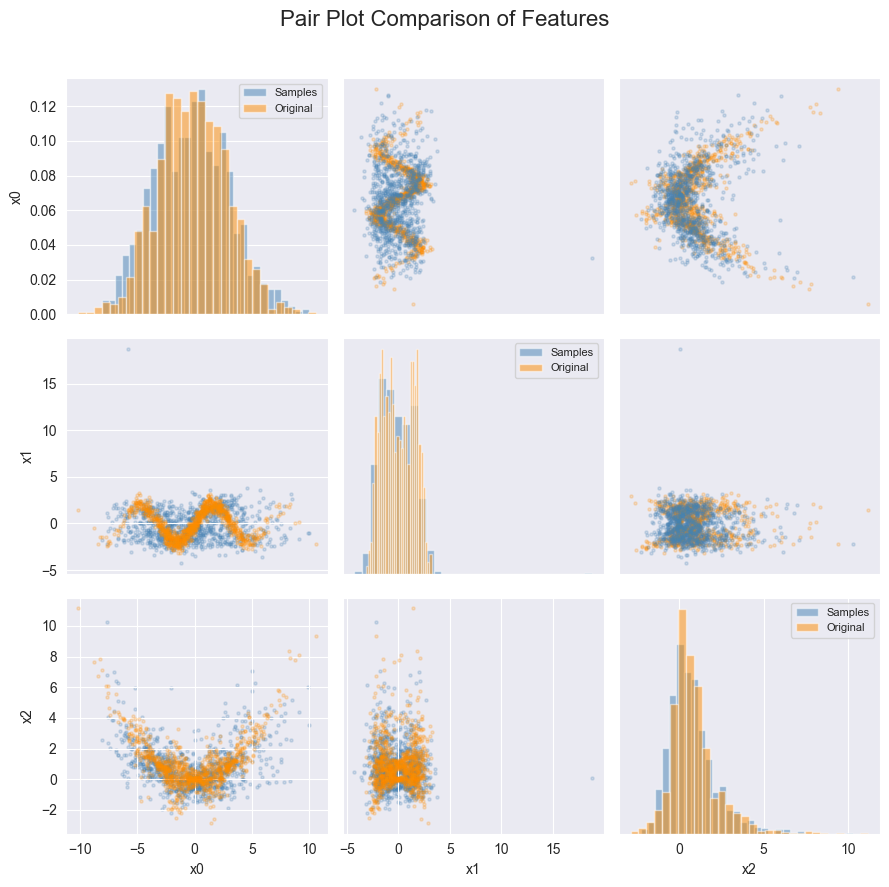

In [31]:
# Full joint estimation
# Taking samples and visualizing them (after some formation)
data_new = data_clean_no_norm[:, :, -1][:1_000]
plot_pairplot_comparison_points(samples, data_new, labels, dataset_labels=('Samples', 'Original'))

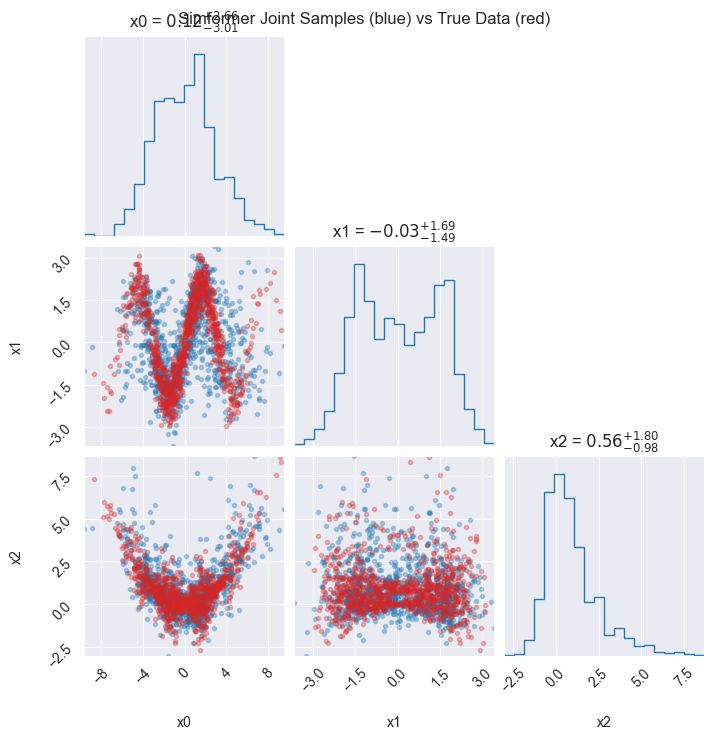

In [11]:
import matplotlib.pyplot as plt
import corner
import numpy as np

labels = [f"x{i}" for i in range(nodes_max)]

# compare on a subset for visualization
samples_plot = samples[:1000]
real_plot = data_clean_no_norm[1000:2000, :, 0]  # shape (B, T)

# Combine samples and data
fig = corner.corner(
    np.asarray(samples_plot),
    color="C0",
    labels=labels,
    show_titles=True,
    title_fmt=".2f",
    truths=None,
    # contour_levels=[0.68, 0.95],
    # smooth=1.,
    plot_density=False,     # disable 2D histograms
    plot_contours=False,    # disable contour plots
    fill_contours=False,    # make sure it's off
)

corner.overplot_points(
    fig=fig,
    xs=np.asarray(samples_plot),
    color="tab:blue",
    alpha=0.3,
)

corner.overplot_points(
    fig=fig,
    xs=np.asarray(real_plot),
    color="tab:red",
    alpha=0.3,
)

plt.suptitle("Simformer Joint Samples (blue) vs True Data (red)")
plt.show()

In [18]:
# Conditional sampling

# Full conditional estimation
theta = jnp.linspace(-10, 10, 1000)
x_o = data_clean[100,:,0]
# standardize the data
x_o_nm = (x_o - means) / stds
true_post = true_posterior(theta, x_o[1], x_o[2])
ys = tsm.sample_fn(jrandom.PRNGKey(0), (1_000,), condition_mask=jnp.array([0,1,1], dtype=int), condition_value=x_o_nm)
samples = (ys[:,-1,:] * stds) + means

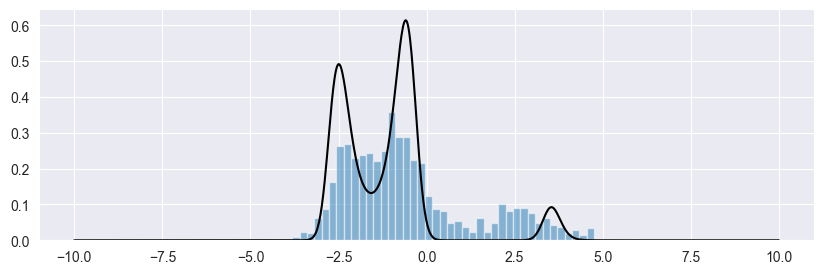

In [19]:
fig = plt.figure(figsize=(10, 3))
plt.plot(theta, true_post, color="k", label="True posterior")
plt.hist(
    samples[:, 0], bins=50, density=True,
    color="C0", alpha=0.5, label="Simformer samples"
)
plt.show()

In [20]:
# Marginal estimation alone (if you leave out marginal consitstency in the loss, this will fail but the above will still work!)
cond_mask = jnp.zeros((1,), dtype=int)
cond_vals = jnp.zeros((1,))
node_ids_fit = jnp.array([0])

marginal_samples1  = tsm.sample_fn(
    jrandom.PRNGKey(0), (1000,), node_ids=node_ids_fit, condition_mask=cond_mask, condition_value=cond_vals
)
marginal_samples2  = tsm.sample_fn(
    jrandom.PRNGKey(0), (1000,), node_ids=node_ids_fit+1, condition_mask=cond_mask, condition_value=cond_vals
)
marginal_samples3 = tsm.sample_fn(
    jrandom.PRNGKey(0), (1000,), node_ids=node_ids_fit+2, condition_mask=cond_mask, condition_value=cond_vals
)

/Users/ratzenboe/Documents/work/projects/AstroSimformer/venv1/lib/python3.10/site-packages/jax/_src/numpy/util.py:74: UserWarning: Following NumPy automatic rank promotion for multiply on shapes (1000, 1) (1,). Set the jax_numpy_rank_promotion config option to 'allow' to disable this warning; for more information, see https://docs.jax.dev/en/latest/rank_promotion_warning.html.
  warnings.warn(msg.format(fun_name, ' '.join(map(str, shapes))))
/Users/ratzenboe/Documents/work/projects/AstroSimformer/venv1/lib/python3.10/site-packages/jax/_src/numpy/util.py:74: UserWarning: Following NumPy automatic rank promotion for add on shapes (1000, 1) (1,). Set the jax_numpy_rank_promotion config option to 'allow' to disable this warning; for more information, see https://docs.jax.dev/en/latest/rank_promotion_warning.html.
  warnings.warn(msg.format(fun_name, ' '.join(map(str, shapes))))


In [21]:
marginal_samples1 = (marginal_samples1[:,-1,:] * stds[0]) + means[0]
marginal_samples2 = (marginal_samples2[:,-1,:] * stds[1]) + means[1]
marginal_samples3 = (marginal_samples3[:,-1,:] * stds[2]) + means[2]

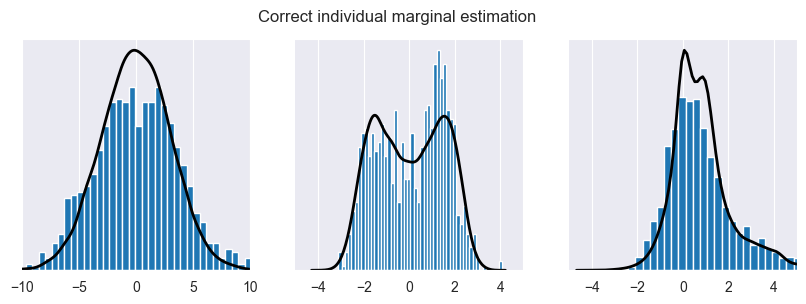

In [22]:
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].hist(marginal_samples1, bins=50, density=True)
ax[1].hist(marginal_samples2[:, 0], bins=50, density=True)
ax[2].hist(marginal_samples3[:, 0], bins=50, density=True)
sns.kdeplot(data_clean_no_norm[:, 0, 0], ax=ax[0], color="black", linewidth=2)
sns.kdeplot(data_clean_no_norm[:, 1, 0], ax=ax[1], color="black", linewidth=2)
sns.kdeplot(data_clean_no_norm[:, 2, 0], ax=ax[2], color="black", linewidth=2)

ax[0].set_xlim(-10,10)
ax[1].set_xlim(-5,5)
ax[2].set_xlim(-5,5)
fig.suptitle("Correct individual marginal estimation")
for ax in ax:
    ax.yaxis.set_visible(False)
    # remove y spines
    ax.spines['left'].set_visible(False)

In [16]:
condition_mask_all_one

NameError: name 'condition_mask_all_one' is not defined